# Macroeconomic dashboard

Alex Wellman, October 2023

In [18]:
import pandas as pd
import numpy as np
import imgkit
import requests
import matplotlib.pyplot as plt
from io import StringIO
%matplotlib inline

In [2]:
# Base URL
base_url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/une_rt_m?format=TSV&unit=PC_ACT"

In [3]:
# Countries of interest
countries = {
    'FR': 'France',
    'DE': 'Germany',
    'IT': 'Italy',
    'US': 'United States'
}

categories_sex = {
    'F': 'Women',
    'M': 'Men',
    'T': 'Total'
}

categories_age = {
    'TOTAL': 'All Ages',
    'Y_LT25': 'Younger than 25'
}

In [4]:
def fetch_data():
    response = requests.get(base_url)
    df = pd.read_csv(StringIO(response.text), sep='\t')
    return df

In [5]:
df = fetch_data()
df

,"freq,s_adj,age,unit,sex,geo\TIME_PERIOD",1983-01,1983-02,1983-03,1983-04,1983-05,1983-06,1983-07,1983-08,1983-09,...,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09
0,"M,NSA,TOTAL,PC_ACT,F,AT",:,:,:,:,:,:,:,:,:,...,4.4,5.2,5.2,4.2,4.9,4.5,4.9,4.9,4.7,:
1,"M,NSA,TOTAL,PC_ACT,F,BE",:,:,:,:,:,:,:,:,:,...,5.1,5.0,4.9,4.8,4.8,4.8,4.9,5.2,5.1,:
2,"M,NSA,TOTAL,PC_ACT,F,BG",:,:,:,:,:,:,:,:,:,...,4.0,4.2,4.3,4.5,4.8,4.7,4.4,4.3,4.1,:
3,"M,NSA,TOTAL,PC_ACT,F,CH",:,:,:,:,:,:,:,:,:,...,4.4,4.5,4.5,4.3,4.0,3.8,3.7,:,:,:
4,"M,NSA,TOTAL,PC_ACT,F,CY",:,:,:,:,:,:,:,:,:,...,8.7,8.0,7.5,6.5,5.5,5.4,6.7,8.0,8.2,:
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892,"M,TC,Y_LT25,THS_PER,T,SE",63,65,66,66,67,68,69,70,71,...,146,146,146,147,147,147,148,149,151,152
1893,"M,TC,Y_LT25,THS_PER,T,SI",:,:,:,:,:,:,:,:,:,...,7,5,5,5,8,8,8,:,:,:
1894,"M,TC,Y_LT25,THS_PER,T,SK",:,:,:,:,:,:,:,:,:,...,28,27,27,27,29,29,29,29,28,:
1895,"M,TC,Y_LT25,THS_PER,T,TR",:,:,:,:,:,:,:,:,:,...,1047,1045,1032,1023,1005,984,982,979,:,:


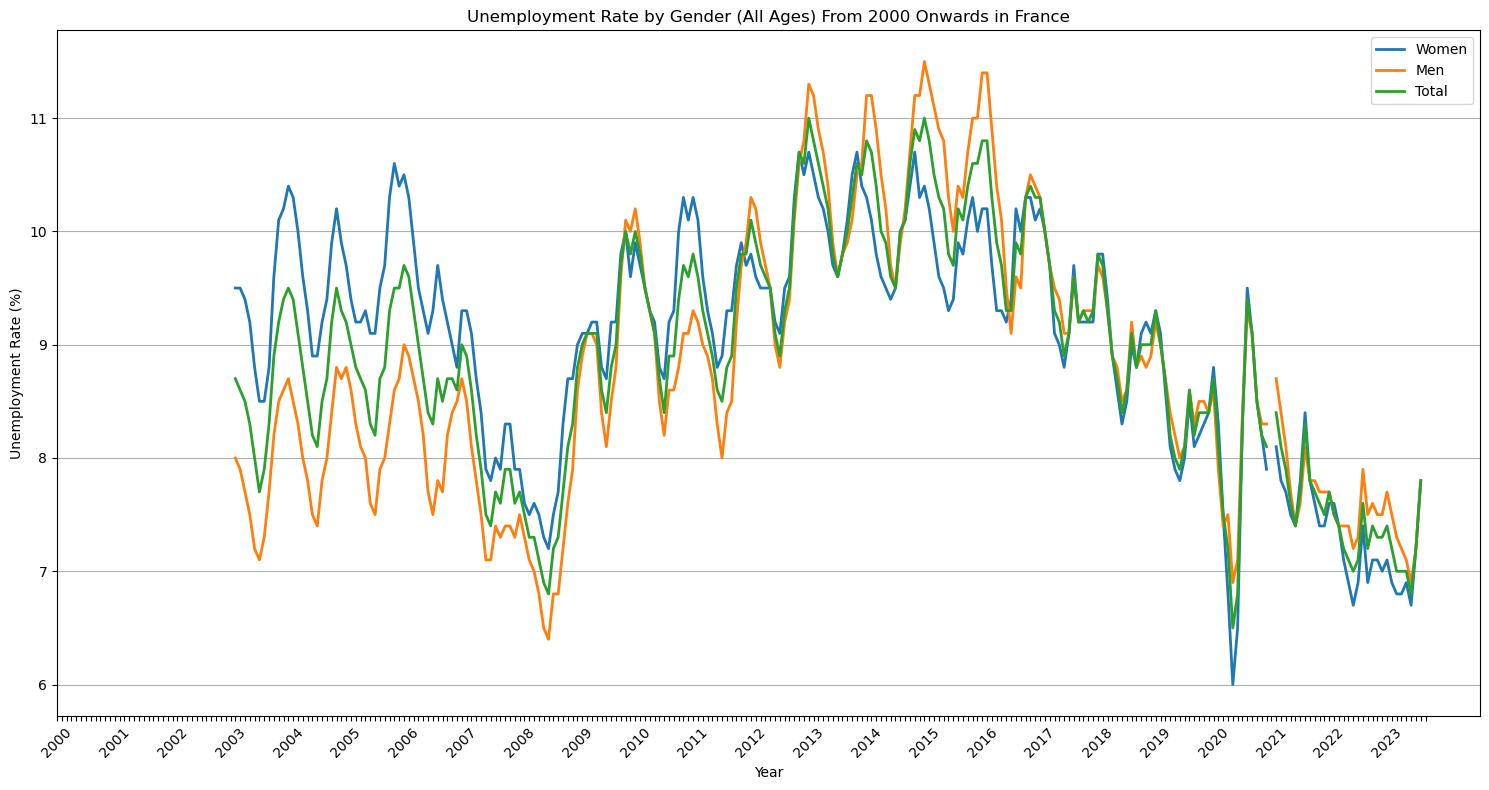

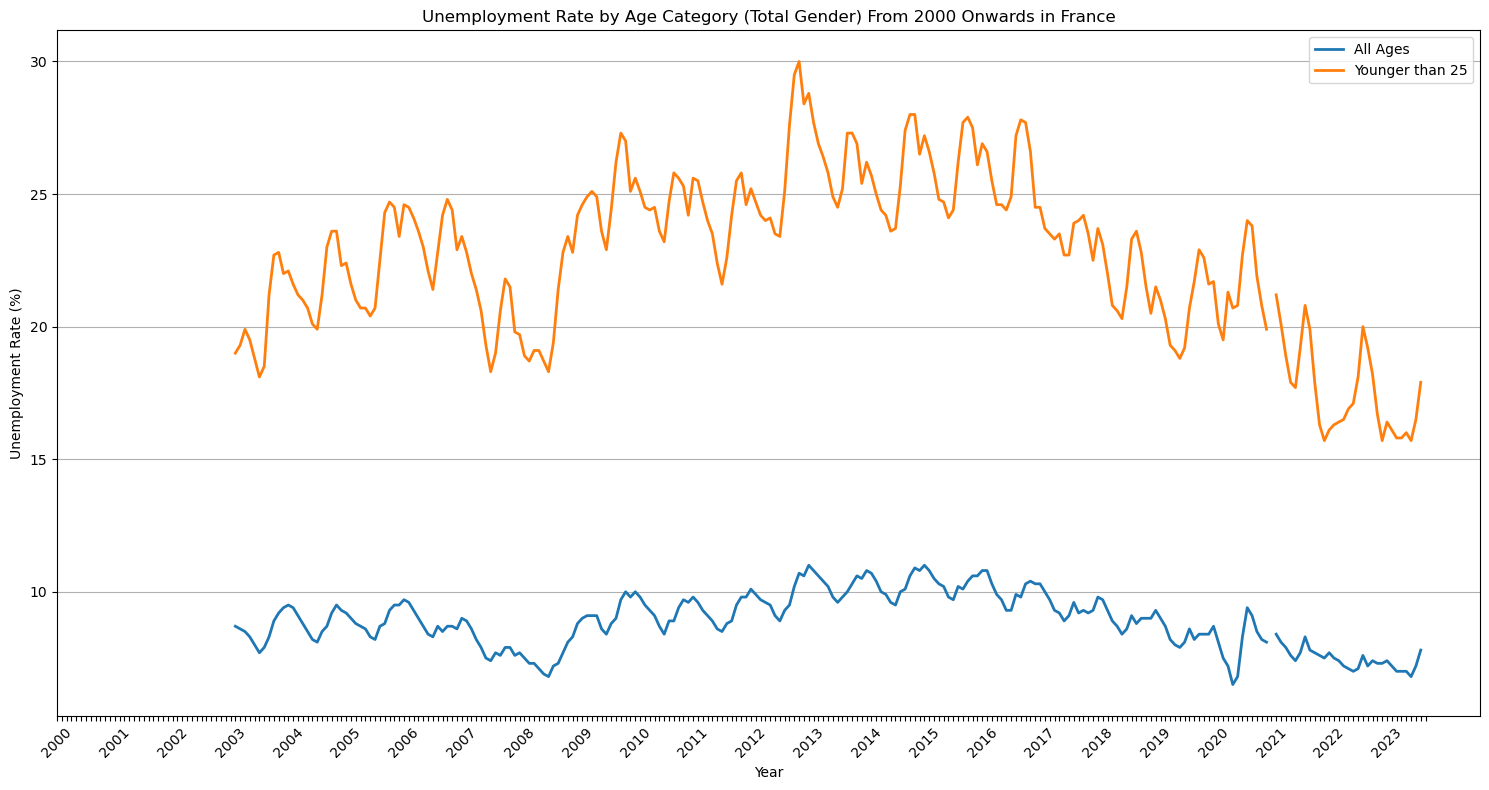

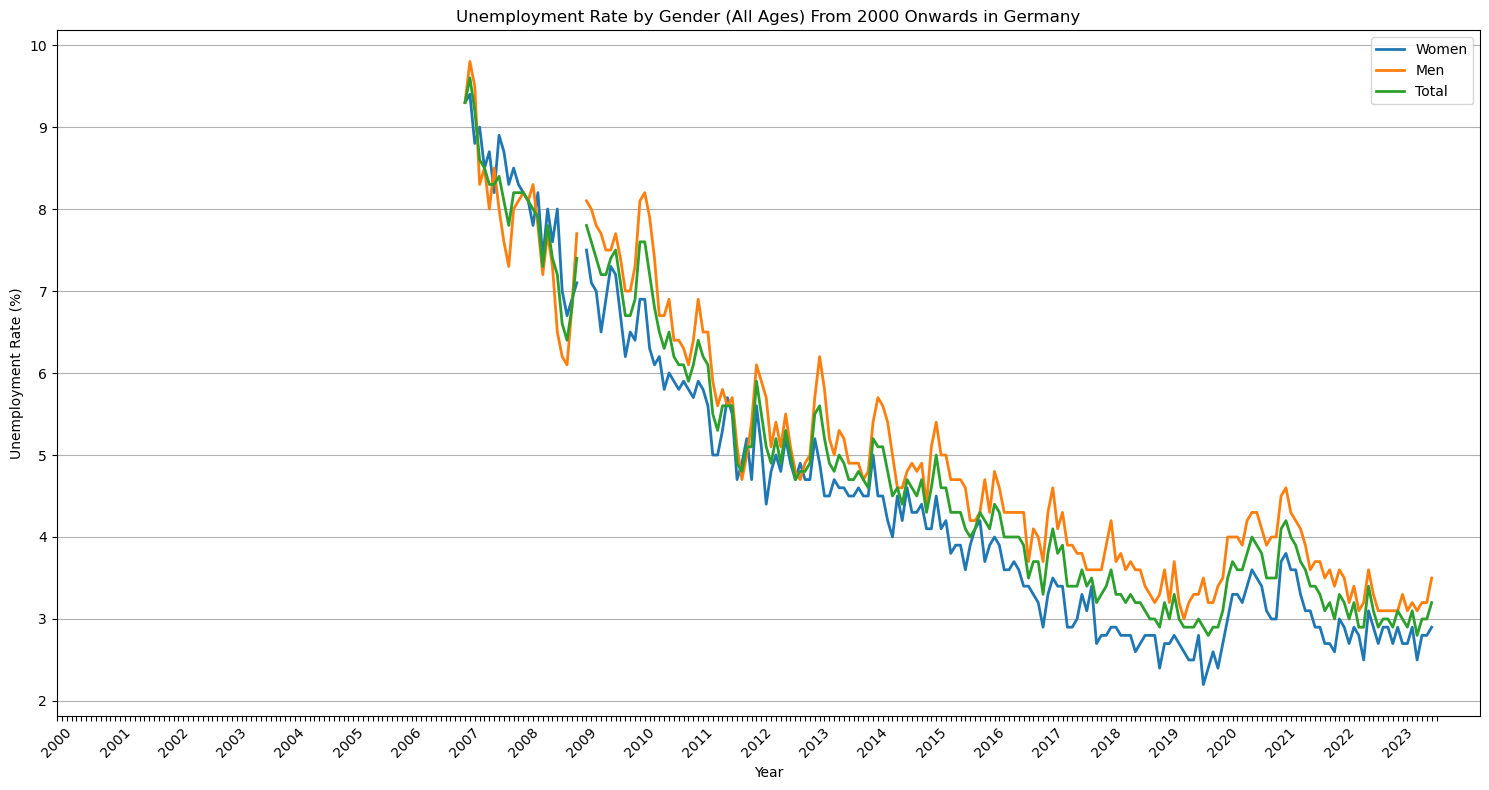

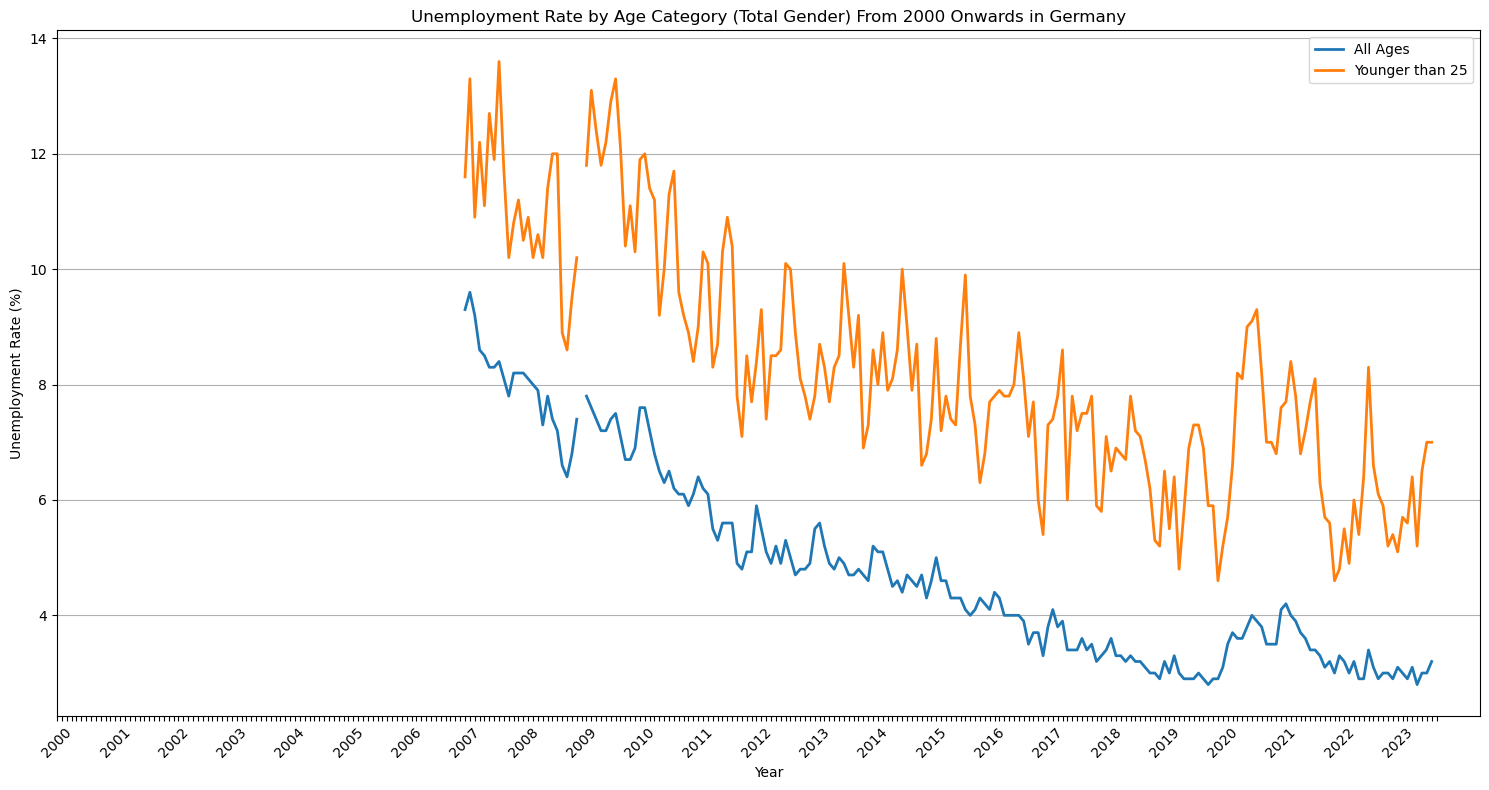

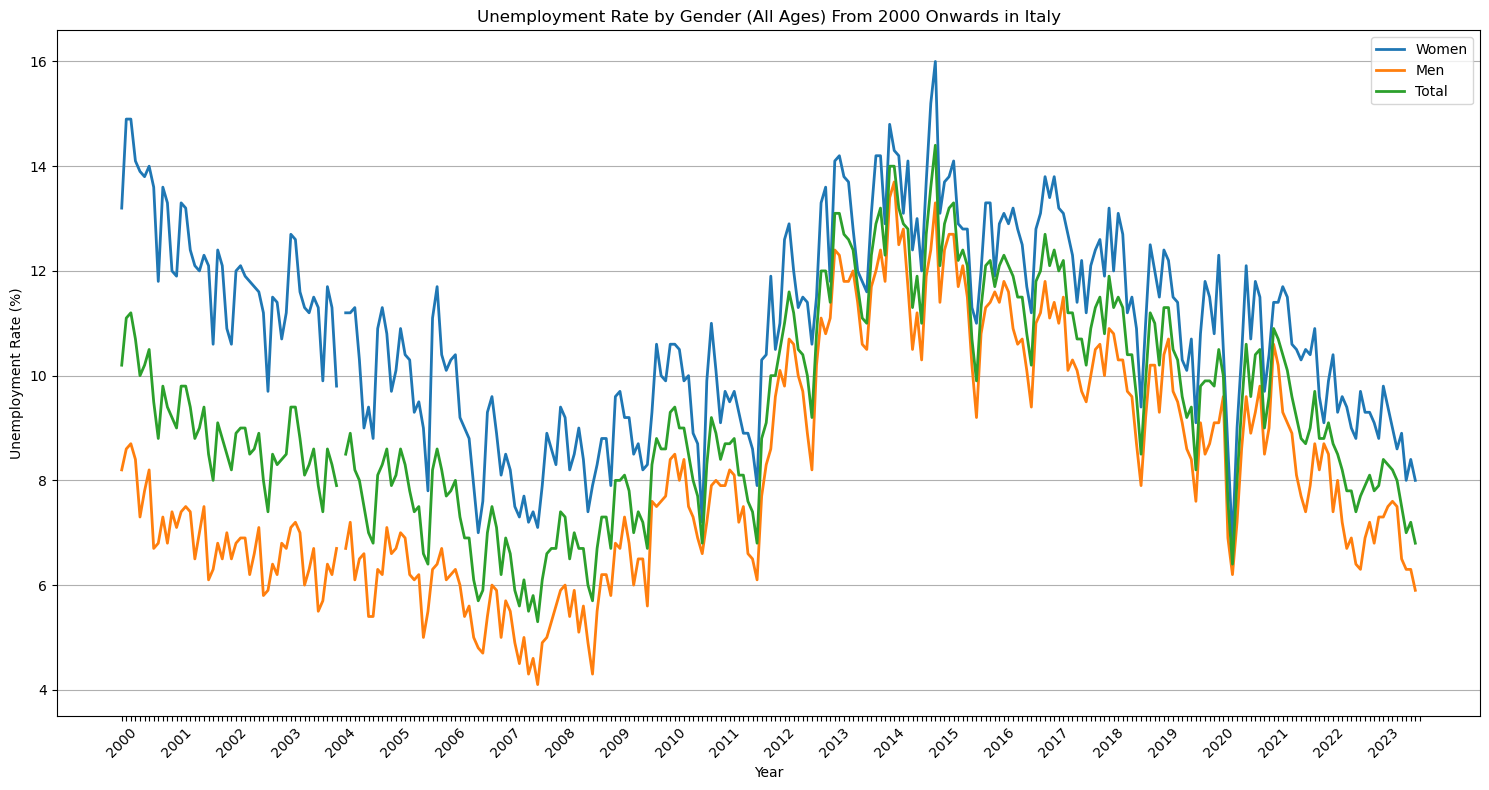

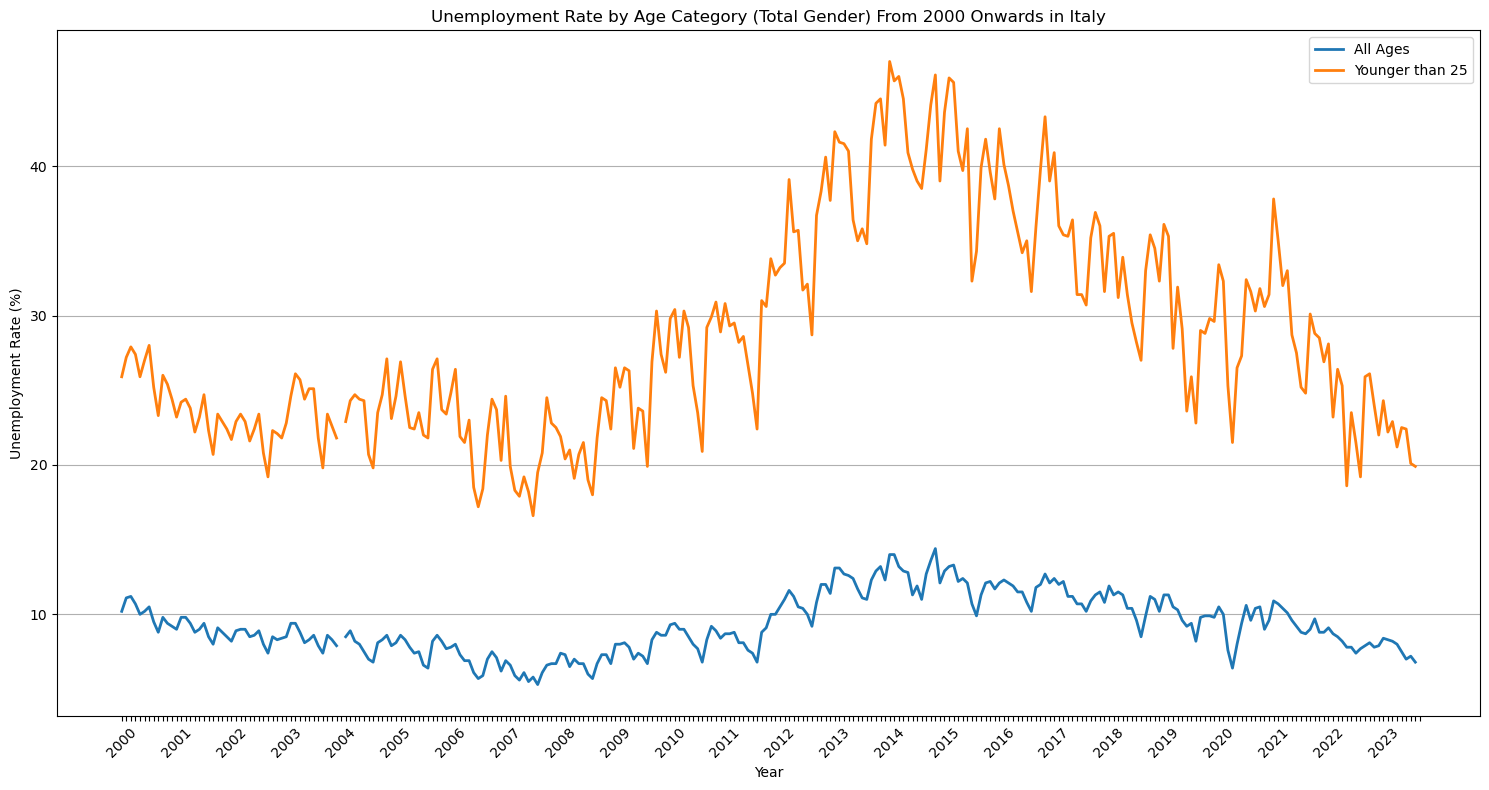

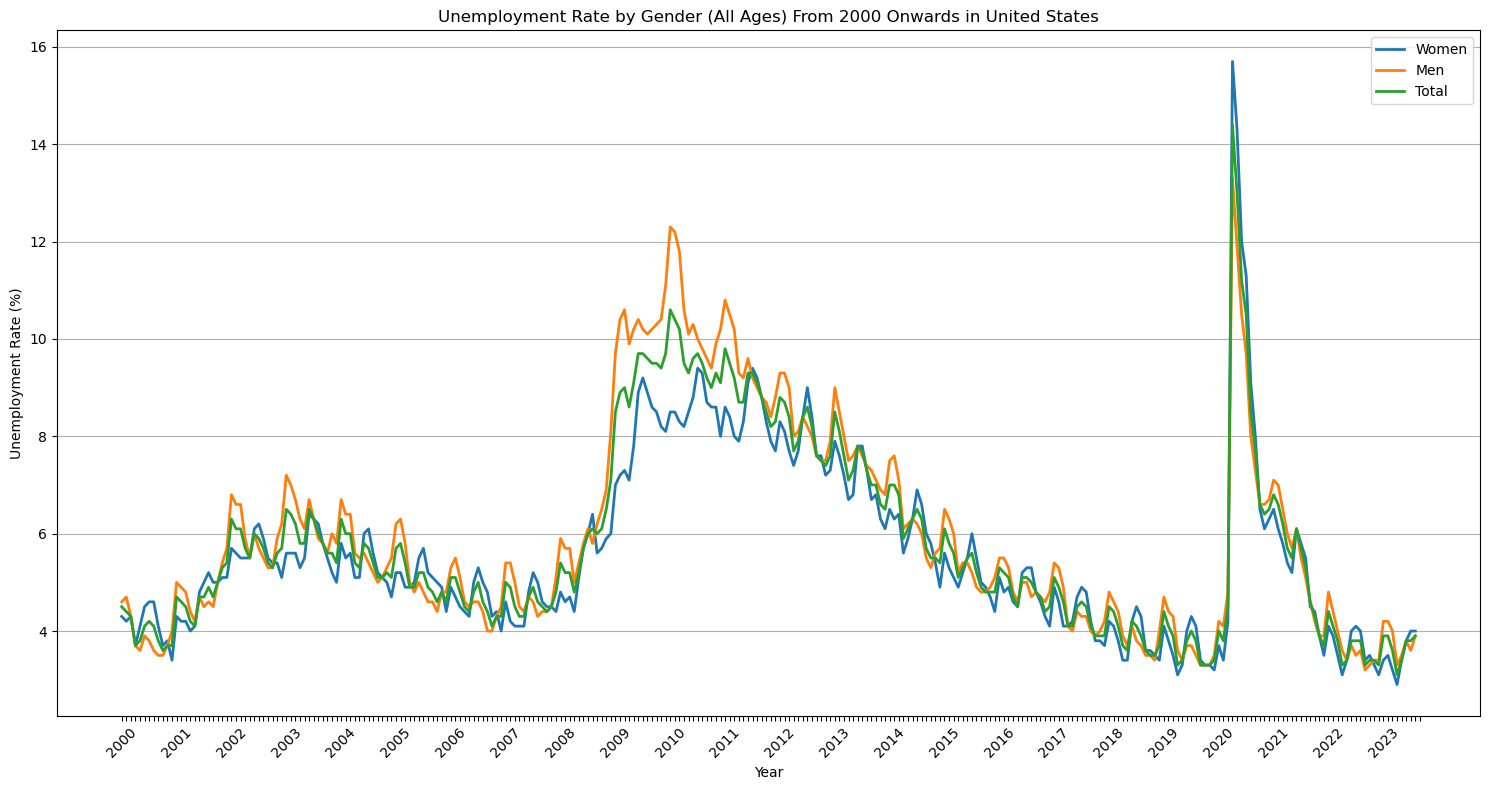

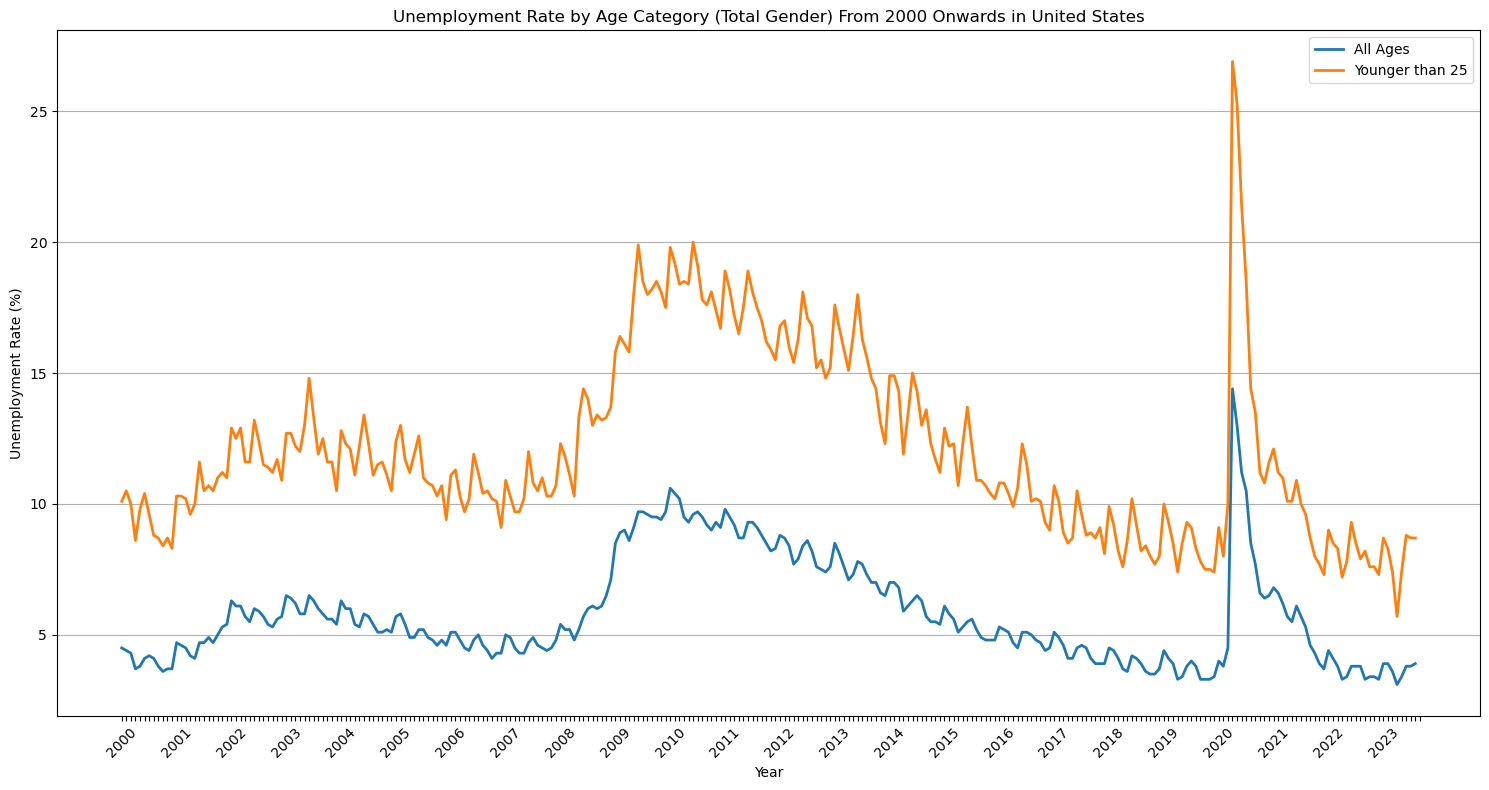

In [6]:
# Plot the fetched data
for country_code, country_name in countries.items():

    # Plotting for different genders (for a specific age category)
    plt.figure(figsize=(15, 8))
    selected_age = 'TOTAL'
    for key_sex, value_sex in categories_sex.items():
        cat_data_raw = df[df.iloc[:, 0] == f'M,NSA,{selected_age},PC_ACT,{key_sex},{country_code}'].iloc[0, 1:]
        cat_data = cat_data_raw.replace(':', float('nan'))
        cat_data = pd.to_numeric(cat_data, errors='coerce')
        times = [time for time in df.columns[1:] if int(time.split('-')[0]) >= 2000]
        cat_data_subset = cat_data[times]
        plt.plot(times, cat_data_subset, label=value_sex, linewidth=2)

    years_labels = [time.split('-')[0] if '-01' in time else '' for time in times]
    plt.xlabel('Year')
    plt.ylabel('Unemployment Rate (%)')
    plt.title(f'Unemployment Rate by Gender (All Ages) From 2000 Onwards in {country_name}')
    plt.xticks(times, labels=years_labels, rotation=45)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f"figures/{country_name}_by_gender.png")    
    
    # Display the figure
    plt.show()

    # Plotting for different age categories (for a specific gender)
    plt.figure(figsize=(15, 8))
    selected_sex = 'T'
    for key_age, value_age in categories_age.items():
        cat_data_raw = df[df.iloc[:, 0] == f'M,NSA,{key_age},PC_ACT,{selected_sex},{country_code}'].iloc[0, 1:]
        cat_data = cat_data_raw.replace(':', float('nan'))
        cat_data = pd.to_numeric(cat_data, errors='coerce')
        times = [time for time in df.columns[1:] if int(time.split('-')[0]) >= 2000]
        cat_data_subset = cat_data[times]
        plt.plot(times, cat_data_subset, label=value_age, linewidth=2)

    years_labels = [time.split('-')[0] if '-01' in time else '' for time in times]
    plt.xlabel('Year')
    plt.ylabel('Unemployment Rate (%)')
    plt.title(f'Unemployment Rate by Age Category (Total Gender) From 2000 Onwards in {country_name}')
    plt.xticks(times, labels=years_labels, rotation=45)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    
    # Show the figure
    plt.savefig(f"figures/{country_name}_by_age.png")
    
    # Display the figure
    plt.show()

In [7]:
# Specified categories
specified_categories = [('M','TOTAL'), ('F','TOTAL'), ('T','TOTAL'), ('T','Y_LT25')]

# Create a list to store the results
results = []

In [8]:
# Loop through the countries
for country_code, country_name in countries.items():

    # Get overall unemployment rate
    overall_data_raw = df[df.iloc[:, 0] == f'M,NSA,TOTAL,PC_ACT,T,{country_code}'].iloc[0, 1:]
    overall_data = overall_data_raw.replace(':', float('nan'))
    overall_data = pd.to_numeric(overall_data, errors='coerce')
    most_recent_overall = overall_data.dropna().iloc[-1] if not overall_data.dropna().empty else None
    results.append({
        'Country': country_name,
        'Category': 'Overall',
        'Most Recent Unemployment Rate': most_recent_overall
    })

    # Loop through the specified categories
    for key_sex, key_age in specified_categories:
        cat_data_raw = df[df.iloc[:, 0] == f'M,NSA,{key_age},PC_ACT,{key_sex},{country_code}'].iloc[0, 1:]
        cat_data = cat_data_raw.replace(':', float('nan'))
        cat_data = pd.to_numeric(cat_data, errors='coerce')

        # Get the most recent data point (last non-NaN value)
        most_recent_data = cat_data.dropna().iloc[-1] if not cat_data.dropna().empty else None

        category_label = f"{categories_sex[key_sex]}, {categories_age[key_age]}"

        # Append to the results list
        results.append({
            'Country': country_name,
            'Category': category_label,
            'Most Recent Unemployment Rate': most_recent_data
        })


In [13]:
# Extract the most recent date from the data (assuming it's the same for all countries and categories)
most_recent_date = df.columns[-1]

# Convert list of dictionaries to a DataFrame
df_heatmap = pd.DataFrame(results)

# Pivot the DataFrame to have countries as columns and categories as index
pivot_df = df_heatmap.pivot(index='Category', columns='Country', values='Most Recent Unemployment Rate')

# Function to color cells based on value
def color_cells(val):
    if val is None or pd.isna(val):
        return 'background-color: #f5f5f5;'  # grey color for NaN or None
    elif val <= 5:
        return 'background-color: #a1d99b;'  # green for low unemployment
    elif val <= 10:
        return 'background-color: #fdcc8a;'  # orange for medium unemployment
    else:
        return 'background-color: #fc9272;'  # red for high unemployment

styled_pivot_df = pivot_df.style.applymap(color_cells).set_caption(f"Unemployment Rates (most recent data from {most_recent_date})").format("{:.2f}%")

In [21]:
# Display styled DataFrame
styled_pivot_df

# Render the styled DataFrame as HTML
styled_html = styled_pivot_df.to_html()

# Save the HTML as an image (PNG)
imgkit.from_string(styled_html, 'figures/unemp_rates.png', options={'format': 'png'})



Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True